In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sqlalchemy import create_engine
from urllib.parse import quote_plus
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
import csv
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error, median_absolute_error
from sklearn.model_selection import GridSearchCV


# Load CSV data
csv_path = './docs/data.csv'
df = pd.read_csv(csv_path, delimiter=';')

# Exploring the data
print(df.head(10))  # Display first few rows
print(df.describe())  # Display summary statistics


In [ ]:
# Checking for missing values
missing_values = df.isnull().sum()

print("Missing Values in Each Column:")
print(missing_values)

In [ ]:
print(df)
df.isnull().sum()
drop_df = df.dropna()
print(drop_df)

In [ ]:
print(df.duplicated().value_counts())
df.drop_duplicates()

In [ ]:
X = df.drop("G3", axis = 1)
print(X.describe())
y = df["G3"]

print(X.shape)
print(y.shape)

In [ ]:
# Define the categorical columns
categorical_columns = [
    'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'
]

# Apply label encoding to categorical columns in X
label_encoder = LabelEncoder()
for column in categorical_columns:
    X[column] = label_encoder.fit_transform(X[column])

# Display the DataFrame after label encoding
print(X.head(10))

In [ ]:
EDA_df = X.copy()

corr_matrix = EDA_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 5})
plt.title("Correlation Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

print(X.head(10))



In [ ]:
EDA_df.hist(bins=20, figsize=(15, 10))
print(X.head(10))


In [ ]:

# Create new features
X['academic_performance'] = X['G1'] + X['G2']
X['study_engagement'] = X['studytime'] * X['absences']
X['social_life'] = X['goout'] * X['freetime']
X['family_support'] = X['famsup'] * X['famrel']
X['health_and_activities'] = X['health'] * X['activities']
X['alcohol_consumption'] = X['Dalc'] + X['Walc']
X['study_habits'] = X['studytime'] * X['failures']
X['parental_education'] = X['Medu'] + X['Fedu']
X['internet_higher_edu'] = X['internet'] * X['higher']
X['Walc_health'] = X['Walc'] * X['health']


# Create a list of subsets to evaluate
featureSets = [
  ['G2', 'academic_performance', 'G1', 'study_engagement'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'romantic'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob', 'sex'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob', 'sex', 'alcohol_consumption'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob', 'sex', 'alcohol_consumption', 'paid'],
  ['G2', 'academic_performance', 'G1', 'study_engagement', 'failures', 'Mjob', 'Walc', 'Fjob', 'sex', 'alcohol_consumption', 'paid', 'schoolsup']
]


# All discrete features should now have integer dtypes
discrete_features = X.dtypes == int


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
print(mi_scores)

In [ ]:

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, color='salmon')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# Assuming mi_scores is the mutual information scores you calculated
plt.figure(figsize=(10, 8))
plot_mi_scores(mi_scores)
plt.show()

In [ ]:

results_df = pd.DataFrame(columns=['Feature Set', 'Model', 'r2', 'MSE', 'mean_absolute_percentage', 'max_error', 'median_absolute_error'])

for features in featureSets:
    try:
        X_features = X[features]

        # Scale features
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_features), columns=X_features.columns)

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Define models
        models = {
            'KNN Regressor': KNeighborsRegressor(),
            'Linear SVR': SVR(),
            'Ridge Regressor': Ridge()
        }

        # Train and evaluate models
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mean_absolute_percentage = mean_absolute_error(y_test, y_pred)
            max_err = max_error(y_test, y_pred)
            medianae = median_absolute_error(y_test, y_pred)

            results_df.loc[len(results_df.index)] = [', '.join(features), model_name, r2, mse, mean_absolute_percentage, max_err, medianae]

    except Exception as e:
        print(f"Error processing feature set {', '.join(features)}: {e}")

# Display results
print(results_df)

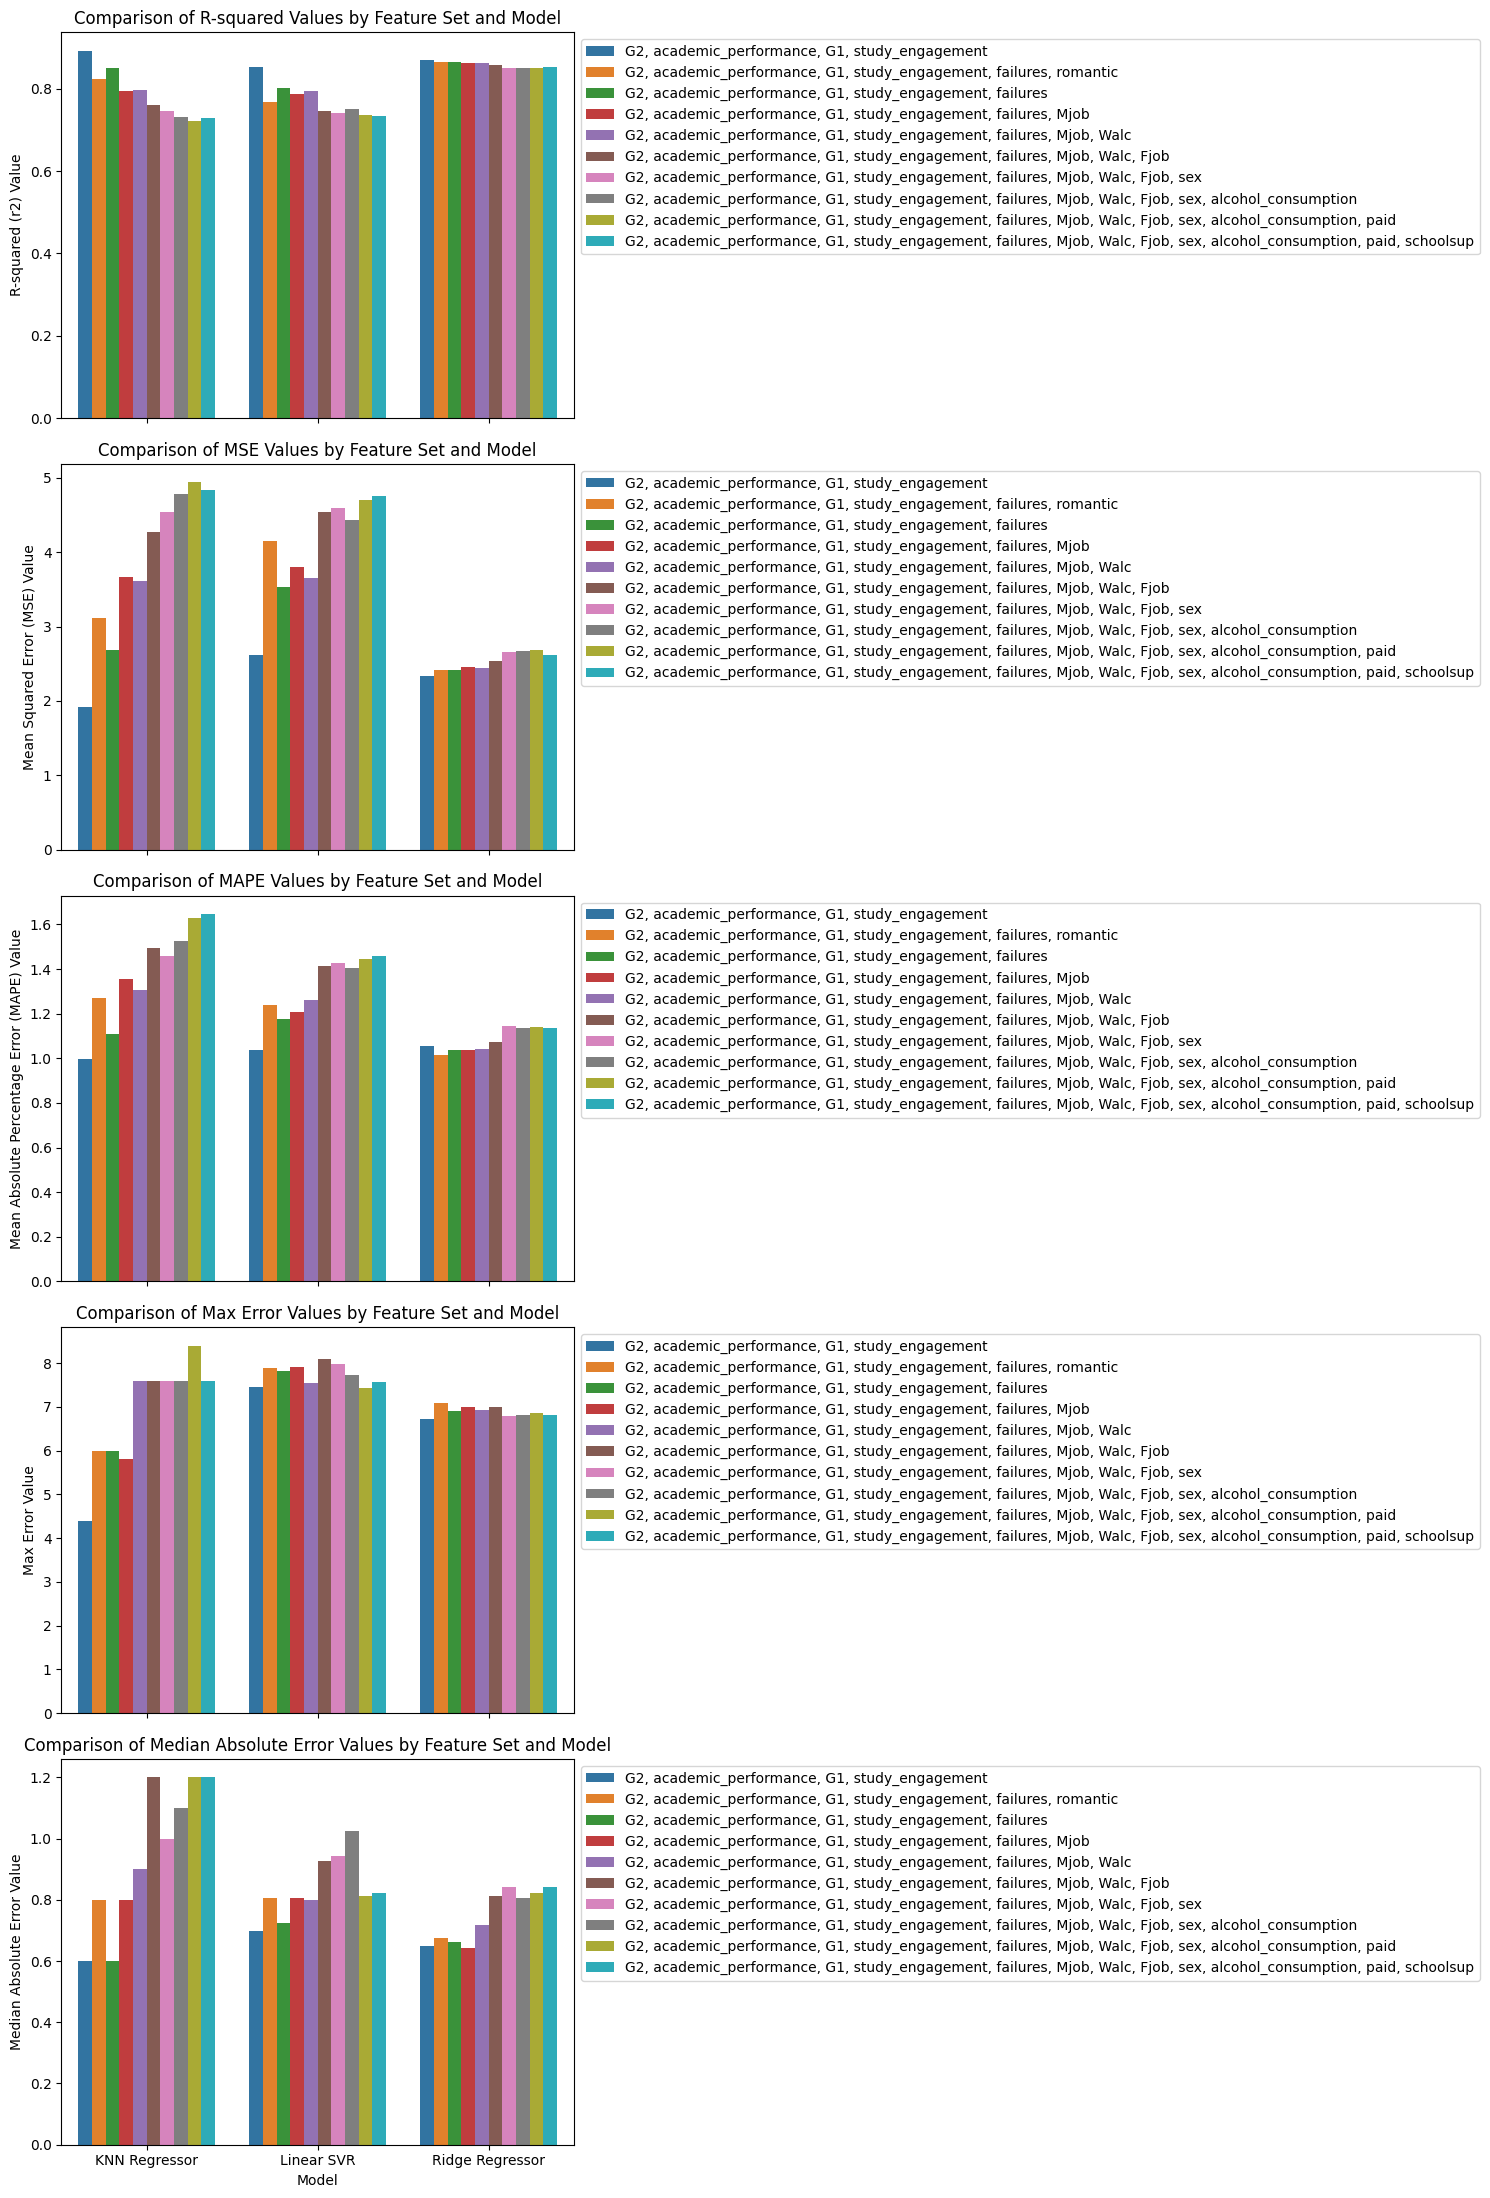

In [48]:
# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(15, 24), sharex=True)

# Bar plot for R-squared (r2)
sns.barplot(x='Model', y='r2', hue='Feature Set', data=results_df, ax=axes[0])
axes[0].set_ylabel('R-squared (r2) Value')
axes[0].set_title('Comparison of R-squared Values by Feature Set and Model')

# Bar plot for Mean Squared Error (MSE)
sns.barplot(x='Model', y='MSE', hue='Feature Set', data=results_df, ax=axes[1])
axes[1].set_ylabel('Mean Squared Error (MSE) Value')
axes[1].set_title('Comparison of MSE Values by Feature Set and Model')

# Bar plot for Mean Absolute Percentage Error (MAPE)
sns.barplot(x='Model', y='mean_absolute_percentage', hue='Feature Set', data=results_df, ax=axes[2])
axes[2].set_ylabel('Mean Absolute Percentage Error (MAPE) Value')
axes[2].set_title('Comparison of MAPE Values by Feature Set and Model')

# Bar plot for Max Error
sns.barplot(x='Model', y='max_error', hue='Feature Set', data=results_df, ax=axes[3])
axes[3].set_ylabel('Max Error Value')
axes[3].set_title('Comparison of Max Error Values by Feature Set and Model')

# Bar plot for Median Absolute Error
sns.barplot(x='Model', y='median_absolute_error', hue='Feature Set', data=results_df, ax=axes[4])
axes[4].set_xlabel('Model')
axes[4].set_ylabel('Median Absolute Error Value')
axes[4].set_title('Comparison of Median Absolute Error Values by Feature Set and Model')

# Move the legend to the upper right corner
for ax in axes:
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout for better visibility
plt.show()


In [ ]:
# Create a figure with subplots
plt.figure(figsize=(25,15))
plt.suptitle("Mean stats per model type")

# Subplot 1: Mean Absolute Error
plt.subplot(1, 5, 1)
plt.bar(results_df['Feature Set'], results_df['mean_absolute_percentage'])
plt.ylim(0.1)
plt.title("Mean Absolute Error")
plt.xticks(rotation='vertical')

# Subplot 2: r2
plt.subplot(1, 5, 2)
plt.bar(results_df['Feature Set'], results_df['r2'])
plt.ylim(0.6)
plt.title("r2")
plt.xticks(rotation='vertical')

# Subplot 3: Mean Squared Error
plt.subplot(1, 5, 3)
plt.bar(results_df['Feature Set'], results_df['MSE'])
plt.title("Mean Squared Error")
plt.xticks(rotation='vertical')

# Subplot 4: Max Error
plt.subplot(1, 5, 4)
plt.bar(results_df['Feature Set'], results_df['max_error'])
plt.title("Max Error")
plt.xticks(rotation='vertical')

# Subplot 5: Median Absolute Error
plt.subplot(1, 5, 5)
plt.bar(results_df['Feature Set'], results_df['median_absolute_error'])
plt.title("Median Absolute Error")
plt.xticks(rotation='vertical')

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout for better visibility
plt.show()


In [ ]:


# Define the parameter grid for KNN Regressor
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_results_df = pd.DataFrame(columns=['Feature Set', 'Model', 'r2', 'MSE', 'mean_absolute_percentage', 'max_error', 'median_absolute_error'])

# Iterate through feature sets
for features in featureSets:
    try:
        X_features = X[features]

        # Scale featuresr m
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_features), columns=X_features.columns)

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Create KNN Regressor model
        knn_model = KNeighborsRegressor()

        # Create GridSearchCV object
        grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')

        # Perform GridSearchCV
        grid_search.fit(X_train, y_train)

        # Get the best hyperparameters
        best_params = grid_search.best_params_

        # Use the best hyperparameters to train the final model
        final_model = KNeighborsRegressor(**best_params)
        final_model.fit(X_train, y_train)

        # Evaluate the final model
        y_pred = final_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mean_absolute_percentage = mean_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        medianae = median_absolute_error(y_test, y_pred)

        # Log results
        grid_results_df.loc[len(grid_results_df.index)] = [', '.join(features), 'KNN Regressor', r2, mse, mean_absolute_percentage, max_err, medianae]

    except Exception as e:
        print(f"Error processing feature set {', '.join(features)}: {e}")

# Display results
print(grid_results_df)


In [ ]:
plt.figure(figsize=(25, 5))
plt.suptitle("Mean stats per feature set")

plt.subplot(1, 5, 1)
plt.bar(grid_results_df['Feature Set'], grid_results_df['mean_absolute_percentage'])
plt.ylim(0.1)
plt.xticks(rotation=45, ha='right') 
plt.title("Mean Absolute Error")

plt.subplot(1, 5, 2)
plt.bar(grid_results_df['Feature Set'], grid_results_df['r2'])
plt.ylim(0.6)
plt.xticks(rotation=45, ha='right') 
plt.title("r2")

plt.subplot(1, 5, 3)
plt.bar(grid_results_df['Feature Set'], grid_results_df['MSE'])
plt.xticks(rotation=45, ha='right')  
plt.title("Mean Squared Error")




In [ ]:
plt.figure(figsize=(25, 5))
plt.suptitle("Mean stats per feature set")

plt.subplot(1, 5, 4)
plt.bar(grid_results_df['Feature Set'], grid_results_df['max_error'])
plt.xticks(rotation=45, ha='right')  
plt.title("Max Error")

plt.subplot(1, 5, 5)
plt.bar(grid_results_df['Feature Set'], grid_results_df['median_absolute_error'])
plt.xticks(rotation=45, ha='right')  
plt.title("Median Absolute Error")

plt.show()